## First meta-analysis

### 1. Meta-analysis using metacont() in R
Given the information contained in our data frame, conducting a meta-analysis is straightforward: the `metacont()` function from the `meta` package will take a series of input arguments that must correspond to the variable names in the data frame. It will then perform the statistical estimation. First we need to load again our data

In [1]:
#######################################################
## Specify R environment for rpy2
#import os
#os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.3'  # Replace with your R path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
import contextlib
# Ipython extension for plotting
%load_ext rpy2.ipython
########################################################

import pandas as pd

# Read the CSV file
pre_data = pd.read_csv(f"../Meta_Analysis/Datasets/dataset02.csv")

# Rename columns 2 to 7
pre_data.columns.values[1:7] = ["n_exp", "mean_exp", "std_exp", "n_con", "mean_con", "std_con"]

# Add a new column 'duration' with values based on the number of rows
pre_data["duration"] = ["> 2 weeks"] * 8 + ["< 2 weeks"] * 9

# Display the first few rows of the dataframe
print(pre_data.head())

             author  n_exp  mean_exp  std_exp  n_con  mean_con  std_con  \
0   Blashki(75%150)     13       6.4      5.4     18      11.4      9.6   
1    Hormazabal(86)     17      11.0      8.2     16      19.0      8.2   
2  Jacobson(75-100)     10      17.5      8.8      6      23.0      8.8   
3       Jenkins(75)      7      12.3      9.9      7      20.0     10.5   
4    Lecrubier(100)     73      15.7     10.6     73      18.7     10.6   

    duration  
0  > 2 weeks  
1  > 2 weeks  
2  > 2 weeks  
3  > 2 weeks  
4  > 2 weeks  


c:\Users\danie\.conda\envs\psy112ER\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
# Activate pandas2ri for automatic conversion
pandas2ri.activate()

# Import the meta package in R
ro.r('library(meta)')

# Put the pre_data DataFrame into the R environment
ro.globalenv['pre_data'] = pandas2ri.py2rpy(pre_data)

# Perform the meta-analysis using metacont
ro.r('''
m <- metacont(n_exp, mean_exp, std_exp, 
              n_con, mean_con, std_con, 
              studlab = author, data = pre_data)
''')

# Print the summary of the meta-analysis
summary = ro.r('summary(m)')
print(summary)

R[write to console]: Loading required package: metadat

R[write to console]: Loading 'meta' package (version 8.0-2).
Type 'help(meta)' for a brief overview.



                        MD               95%-CI %W(common) %W(random)
Blashki(75%150)    -5.0000 [-10.3184;   0.3184]        0.4        5.7
Hormazabal(86)     -8.0000 [-13.5980;  -2.4020]        0.4        5.4
Jacobson(75-100)   -5.5000 [-14.4067;   3.4067]        0.1        3.1
Jenkins(75)        -7.7000 [-18.3906;   2.9906]        0.1        2.3
Lecrubier(100)     -3.0000 [ -6.4388;   0.4388]        0.9        8.0
Murphy(100)        -6.0000 [-11.8718;  -0.1282]        0.3        5.2
Nandi(97)         -27.7000 [-41.0546; -14.3454]        0.1        1.6
Petracca(100)      -3.8000 [-10.3084;   2.7084]        0.3        4.6
Philipp(100)        0.4000 [ -1.2777;   2.0777]        3.9       10.1
Rampello(100)      -6.3000 [ -7.4249;  -5.1751]        8.8       10.6
Reifler(83)         0.0000 [ -5.6445;   5.6445]        0.3        5.4
Rickels(70)        -0.5500 [ -0.9201;  -0.1799]       81.0       11.0
Robertson(75)      -4.0000 [-10.3038;   2.3038]        0.3        4.8
Rouillon(98)       -

### 2. Graphical Output

A very characteristic plot summarizing meta-analytic results is known as the "forest plot". In such a figure, study-specific estimates are displayed, along with fixed and random effects (to be explained later). 

We use the next code chunk to plot a "forest plot" by fitting the object "m" into the `forest()` function:


In [3]:
%%R

# Save the forest plot as a PNG file with larger dimensions
png("../Meta_Analysis/Datasets/forest_plot1.png", width = 2000, height = 800, res = 150)

# Generate the forest plot
forest(m)

# Close the PNG device
dev.off()

png 
  2 


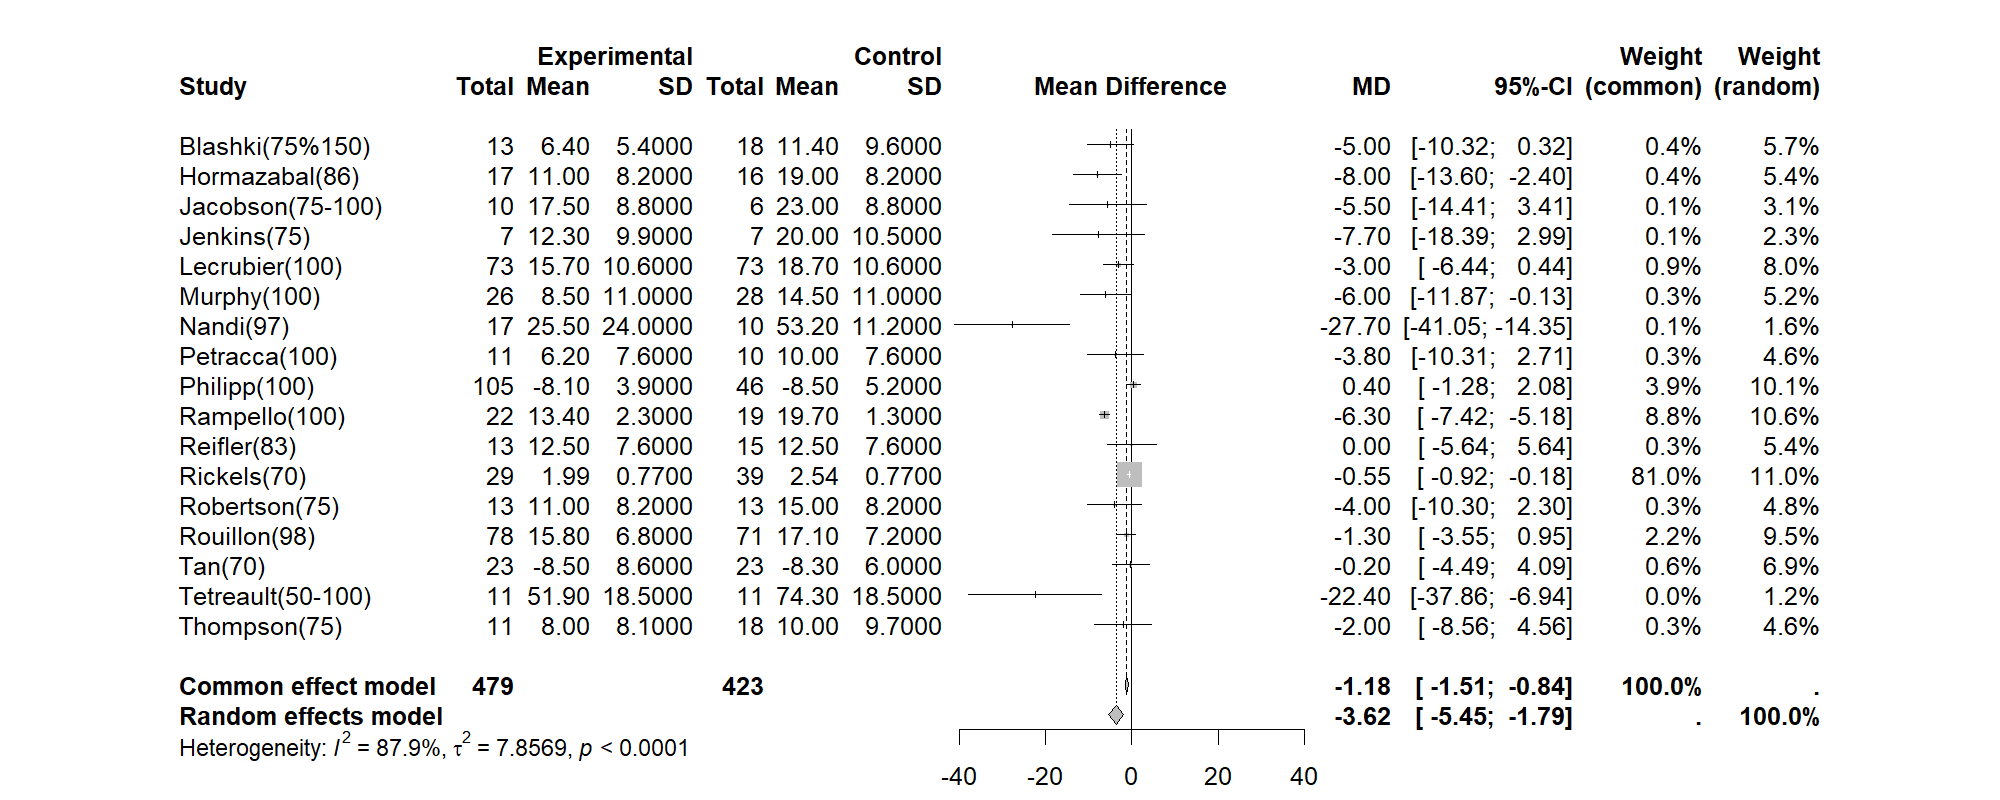

In [4]:
# show the plot
from IPython.display import Image, display

# Display the saved plot
display(Image(filename="../Meta_Analysis/Datasets/forest_plot1.png"))


### 3. Interpretation

* For each study, means and standard deviations in the control and experimental group were extracted from the articles.

* In the middle of the plot, the estimated mean difference between the control and intervention groups and its 95%
confidence intervals are depicted. Next to it on the right side, the mean differences and 95% confidence intervals are numerically displayed. 

* The gray-shaded squares' area represents the precision of the results. It is proportionally calculated as the inverse of the variance of the study estimate. Larger squares indicate studies with more precise results, normally dependent on the study sample sizes. 

* The "Weight(fixed)" and "Weight(random)" columns reflect the percentage weight assigned to each study (i.e., how much each individual study contributes to a general effect measure: fixed or random effect).

* At the lower part of the forest graph, random and fixed effects (explained later in this tutorial) are displayed and right below them, heterogeneity measures: $\ I^2$ is a scaled heterogeneity measure ranging from 0% to 100% and representing the heterogeneity between the individual studies included in the meta-analysis. $\tau^2$ is estimated when working under the random effect model because it measures the between-study variance (it assumes that there is not a unique population, but several ones with their own true effect). It tests the null hypothesis under which the heterogeneity is equal to 0. As indicated by the p-value, this hypothesis is rejected, meaning that there is substantial heterogeneity between the studies included in the meta-analysis.

### 4. Individual studies

The `metacont()` function can also return mean difference and 95% confidence intervals for individual studies. By including the "subset" argument it is possible to obtain single-study estimates. In this case, a z-score with its significance level is provided. 

In [5]:
# Perform the meta-analysis using metacont
study1 = ro.r('''
              metacont(n_exp, mean_exp, std_exp, 
              n_con, mean_con, std_con, 
              studlab = author, data = pre_data, subset = 1)
''')

# Print the summary of the meta-analysis
print(study1)

Number of observations: o = 31 (o.e = 13, o.c = 18)

                     MD             95%-CI     z p-value
Blashki(75%150) -5.0000 [-10.3184; 0.3184] -1.84  0.0654

